# Faster R-CNN Model Evaluation and Visualization

This notebook evaluates the Faster R-CNN model trained by `train_rcnn.py`.

**Key Features:**
1.  **Load Latest Model**: Loads the `latest.pt` checkpoint from a training run.
2.  **Evaluate on Test Set**: Computes COCO metrics (mAP, AP50, AP75) on the unseen test set.
3.  **Calculate Performance Metrics**: Calculates inference speed (FPS), Car Count Accuracy, and Mean Absolute Error (MAE) for model comparison.
4.  **Visualize Predictions**: Shows a side-by-side comparison of ground truth and model predictions on test images.

<b>Note: Training script could not be run on jupyter notebook due to multithreading issues! Refer to train_rcnn.py</b>

## 1. Setup and Configuration

This section imports necessary libraries and defines the paths to the model, data, and training artifacts. Please ensure the paths below are configured correctly for your project structure.

In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import json
from pathlib import Path
import time
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
RUN_DIR = Path('./runs/rcnn/')  # Directory where 'latest.pt' is saved
DATA_DIR = Path('./data/')      # Directory containing the 'test' folder and 'test.json'
MODEL_CHECKPOINT = RUN_DIR / 'latest.pt'
TEST_JSON = DATA_DIR / 'test.json'
TEST_IMG_DIR = DATA_DIR / 'test'

# --- Evaluation Parameters ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 2  # 1 (car) + 1 (background)
BATCH_SIZE = 4
NUM_WORKERS = 0  # Set to 0 to prevent multiprocessing issues in Jupyter. This was a consistent issue I did not know how to fix...
SCORE_THRESHOLD = 0.5 # Threshold for counting predictions and visualization

# Check that paths exist
if not MODEL_CHECKPOINT.exists():
    raise FileNotFoundError(f"Model checkpoint not found at: {MODEL_CHECKPOINT}")
if not TEST_JSON.exists():
    raise FileNotFoundError(f"Test annotations not found at: {TEST_JSON}")
if not TEST_IMG_DIR.exists():
    raise FileNotFoundError(f"Test images not found at: {TEST_IMG_DIR}")

print(f"Device: {DEVICE}")
print(f"Using model: {MODEL_CHECKPOINT}")
print(f"Using test data: {TEST_JSON}")

Device: cuda
Using model: runs\rcnn\latest.pt
Using test data: data\test.json


## 2. Helper Functions and Classes

The helper functions and classes from the training script are included here to make the notebook self-contained.

In [2]:
# Model definition function from the training script
def get_model(num_classes, anchor_sizes=None, pretrained=False):
    # Note: pretrained=False because we are loading our own trained weights.
    # Use the V2 model if available, otherwise fallback
    try:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
        print("Using FasterRCNN_ResNet50_FPN_V2 architecture.")
    except AttributeError:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
        print("Using FasterRCNN_ResNet50_FPN architecture.")
    
    if anchor_sizes is not None:
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
        model.rpn.anchor_generator = anchor_generator
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# COCODataset class from the training script
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, json_file, img_dir, transforms=None):
        from pycocotools.coco import COCO
        self.img_dir = Path(img_dir)
        self.transforms = transforms
        self.coco = COCO(str(json_file))
        self.ids = list(sorted(self.coco.imgs.keys()))
    
    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        coco_anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = self.img_dir / img_info['file_name']
        img = Image.open(img_path).convert('RGB')
        
        boxes, labels = [], []
        for ann in coco_anns:
            x, y, w, h = ann['bbox']
            if w <= 0 or h <= 0: continue
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64),
            "image_id": torch.tensor([img_id])
        }
        
        if self.transforms:
            img_tensor = self.transforms(img)
        
        return img_tensor, target, img # Return original PIL image for visualization
    
    def __len__(self):
        return len(self.ids)

# Transforms and collate function
def get_transform():
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

## 3. Load Model and Test Data

In [3]:
# Load training arguments to check for custom anchor sizes
args_file = RUN_DIR / 'args.json'
anchor_sizes = None
if args_file.exists():
    with open(args_file, 'r') as f:
        train_args = json.load(f)
    if train_args.get('anchor_sizes'):
        anchor_sizes = tuple(tuple([int(s)]) for s in train_args['anchor_sizes'].split(','))
        print(f"Using custom anchor sizes from training: {anchor_sizes}")
else:
    print("Training args.json not found, using default model parameters.")

# Load model
model = get_model(num_classes=NUM_CLASSES, anchor_sizes=anchor_sizes)
checkpoint = torch.load(MODEL_CHECKPOINT, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()
print("Model loaded successfully!")

# Create test dataset and dataloader
test_dataset = COCODataset(TEST_JSON, TEST_IMG_DIR, transforms=get_transform())

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)

print(f"\nTest dataset contains {len(test_dataset)} images.")

Using FasterRCNN_ResNet50_FPN_V2 architecture.
Model loaded successfully!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!

Test dataset contains 99 images.


## 4. Evaluate Model on Test Set (COCO Metrics)

This function runs the model on the test set, computes the standard COCO evaluation metrics, and returns the detailed stats.

In [4]:
@torch.no_grad()
def evaluate(model, data_loader, device, coco_gt):
    from pycocotools.cocoeval import COCOeval
    
    model.eval()
    coco_results = []
    
    for images, targets, _ in tqdm(data_loader, desc="Generating Predictions"):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for target, output in zip(targets, outputs):
            image_id = target['image_id'].item()
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            
            mask = scores > 0.05
            boxes, scores, labels = boxes[mask], scores[mask], labels[mask]
            
            for box, score, label in zip(boxes, scores, labels):
                if label == 0: continue
                x1, y1, x2, y2 = box
                w, h = x2 - x1, y2 - y1
                if w <= 0 or h <= 0: continue
                
                coco_results.append({
                    'image_id': int(image_id),
                    'category_id': 1,
                    'bbox': [float(x1), float(y1), float(w), float(h)],
                    'score': float(score)
                })
                
    if not coco_results:
        print("\nNo predictions were made. Cannot evaluate.")
        return None
        
    print(f"\nGenerated {len(coco_results)} predictions.")

    if 'info' not in coco_gt.dataset:
        coco_gt.dataset['info'] = []
        
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    return coco_eval.stats

# Run COCO evaluation and store the stats
coco_stats = evaluate(model, test_loader, DEVICE, test_dataset.coco)

Generating Predictions: 100%|██████████| 25/25 [00:45<00:00,  1.83s/it]



Generated 5699 predictions.
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.24s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.

## 5. Calculate Key Performance Metrics

This section calculates the inference speed (FPS) and counting performance, organizing the most important metrics into a clear summary for model comparison.

In [5]:
@torch.no_grad()
def calculate_fps(model, data_loader, device):
    model.eval()
    print("Performing warm-up runs for FPS calculation...")
    for i, (images, _, _) in enumerate(data_loader):
        if i >= 3: break
        images = [img.to(device) for img in images]
        _ = model(images)

    print("Calculating FPS...")
    total_time, num_images = 0, 0
    for images, _, _ in tqdm(data_loader, desc="Measuring Inference Speed"):
        images = [img.to(device) for img in images]
        start_time = time.time()
        _ = model(images)
        end_time = time.time()
        total_time += (end_time - start_time)
        num_images += len(images)
    return num_images / total_time if total_time > 0 else 0

@torch.no_grad()
def calculate_counting_metrics(model, data_loader, device, score_threshold):
    model.eval()
    correct_counts, total_images, total_absolute_error = 0, 0, 0
    for images, targets, _ in tqdm(data_loader, desc="Calculating Counting Metrics"):
        images = [img.to(device) for img in images]
        outputs = model(images)
        for i in range(len(images)):
            gt_count = len(targets[i]['labels'])
            pred_scores = outputs[i]['scores']
            pred_count = (pred_scores > score_threshold).sum().item()
            
            total_absolute_error += abs(gt_count - pred_count)
            if gt_count == pred_count:
                correct_counts += 1
            total_images += 1
            
    exact_accuracy = (correct_counts / total_images) * 100 if total_images > 0 else 0
    mae = total_absolute_error / total_images if total_images > 0 else 0
    return exact_accuracy, mae

# Calculate metrics
fps = calculate_fps(model, test_loader, DEVICE)
count_accuracy, count_mae = calculate_counting_metrics(model, test_loader, DEVICE, SCORE_THRESHOLD)

# --- Display Summary --- #
print("\n" + "="*50)
print("            Model Performance Summary")
print("="*50)
if coco_stats is not None:
    print(f" Bbox AP @ IoU=.50:.95:              {coco_stats[0]:.4f}")
    print(f" Bbox AP @ IoU=.50:                   {coco_stats[1]:.4f}")
    print(f" Bbox AR @ maxDets=100:             {coco_stats[8]:.4f}")
else:
    print(" Bounding box metrics not available.")
print("-"*50)
print(f" Car Count Exact Accuracy:            {count_accuracy:.2f}%")
print(f" Car Count Mean Absolute Error (MAE): {count_mae:.4f}")
print("-"*50)
print(f" Inference Speed (FPS):               {fps:.2f}")
print("="*50)

Performing warm-up runs for FPS calculation...
Calculating FPS...


Calculating Counting Metrics: 100%|██████████| 25/25 [00:45<00:00,  1.83s/it]


            Model Performance Summary
 Bbox AP @ IoU=.50:.95:              0.7696
 Bbox AP @ IoU=.50:                   0.9881
 Bbox AR @ maxDets=100:             0.8177
--------------------------------------------------
 Car Count Exact Accuracy:            25.25%
 Car Count Mean Absolute Error (MAE): 1.4747
--------------------------------------------------
 Inference Speed (FPS):               2.35


## 6. Visualize Predictions on Test Images

Finally, let's see the model in action. We'll sample a few images from the test set and draw both the ground truth bounding boxes and the model's predicted boxes. This provides a qualitative assessment of the model's performance.

-   **Green Boxes**: Ground Truth
-   **Red Boxes**: Model Predictions (with confidence scores)

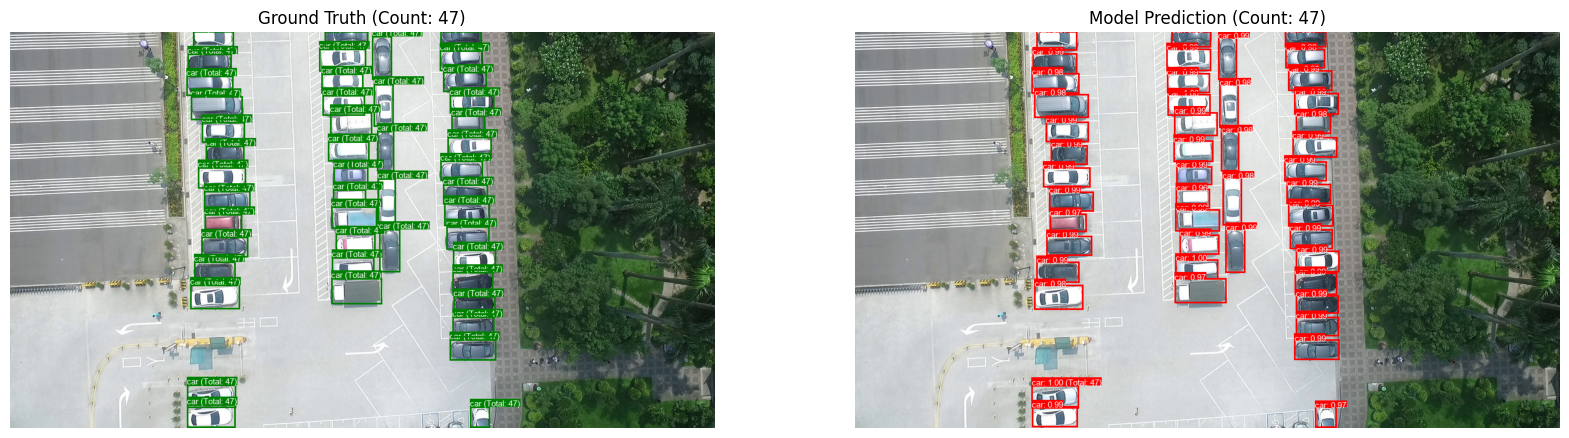

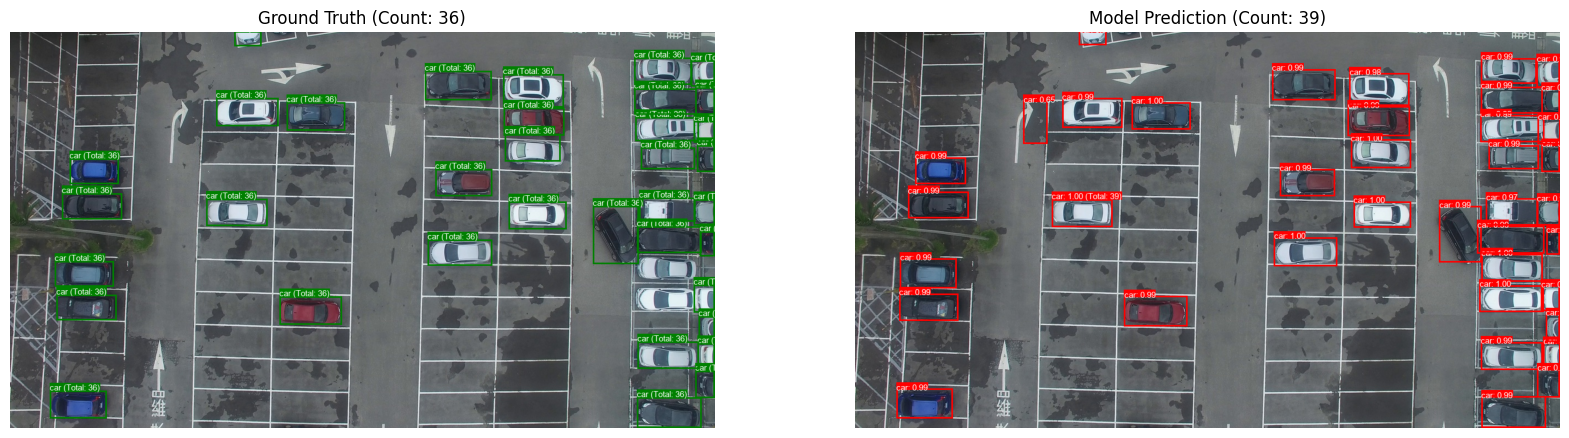

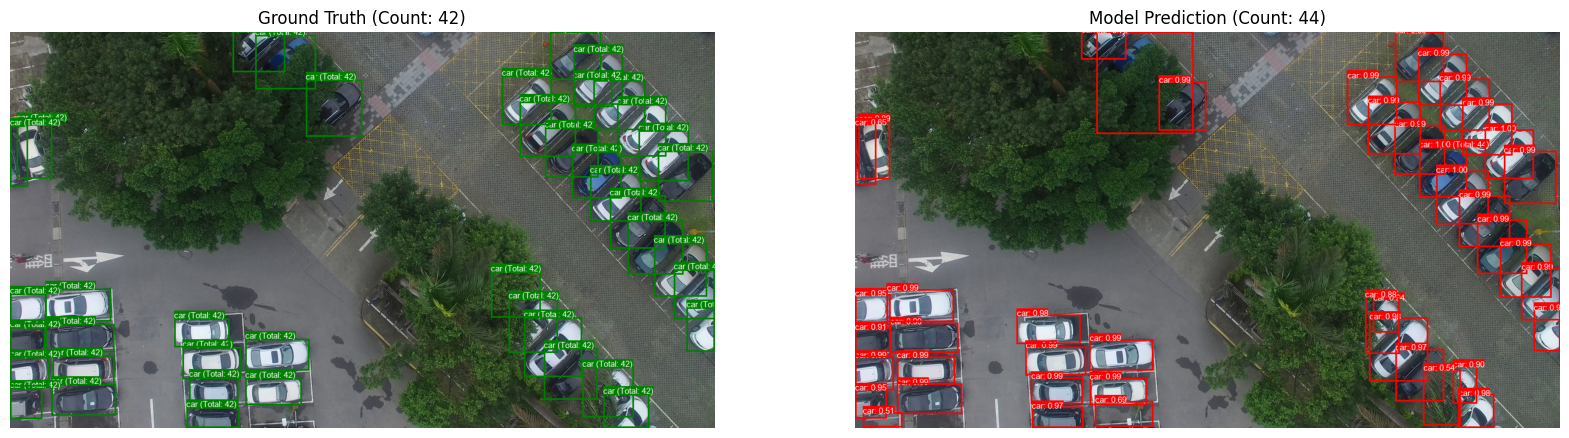

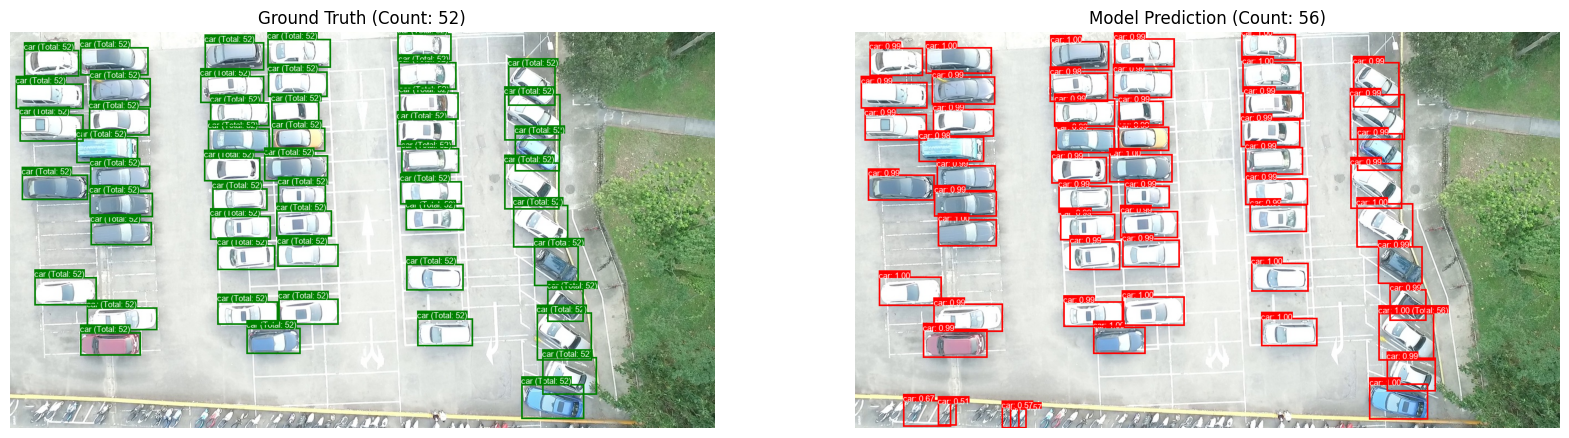

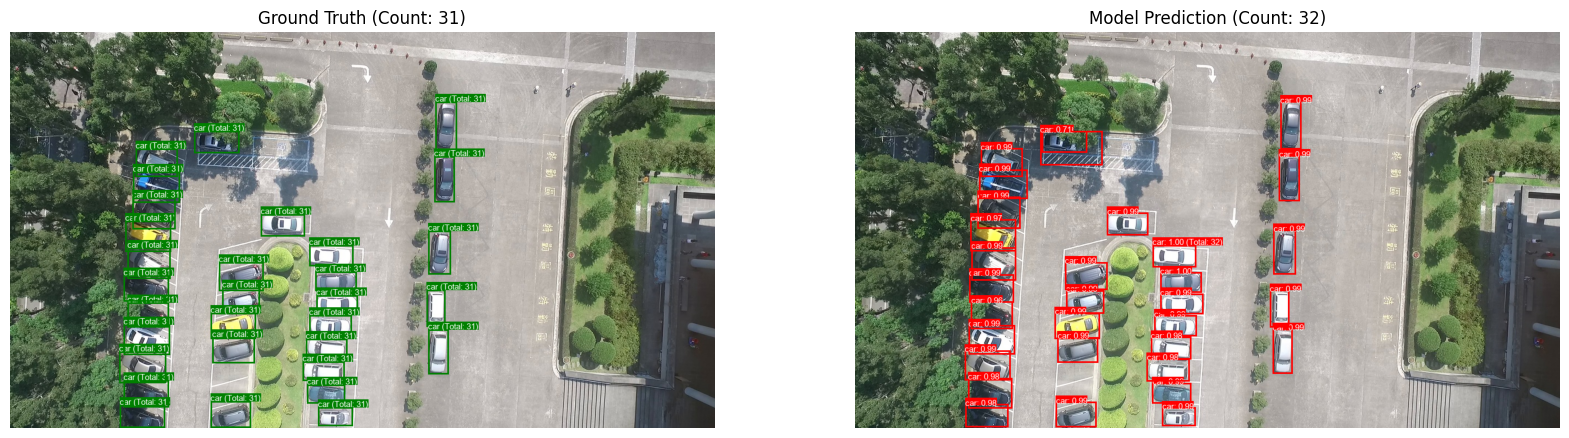

In [6]:
def draw_boxes(image, boxes, labels, color, text_prefix=''):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    for box, label in zip(boxes, labels):
        draw.rectangle(list(box), outline=color, width=3)
        text = f"{text_prefix}{label}"
        text_size = draw.textbbox((0,0), text, font=font)
        text_width = text_size[2] - text_size[0]
        text_height = text_size[3] - text_size[1]
        draw.rectangle([box[0], box[1] - text_height, box[0] + text_width, box[1]], fill=color)
        draw.text((box[0], box[1] - text_height), text, fill="white", font=font)

def visualize_predictions(model, dataset, num_samples=5, score_threshold=0.5):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx in indices:
        img_tensor, target, original_img = dataset[idx]
        
        # --- Ground Truth ---
        gt_img = original_img.copy()
        gt_boxes = target['boxes'].numpy()
        gt_count = len(gt_boxes)
        gt_labels = [f"car (Total: {gt_count})"] * gt_count if gt_count > 0 else []
        draw_boxes(gt_img, gt_boxes, gt_labels, color='green')
        
        # --- Prediction ---
        model.eval()
        with torch.no_grad():
            prediction = model([img_tensor.to(DEVICE)])[0]
        
        pred_img = original_img.copy()
        boxes = prediction['boxes'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()
        
        mask = scores > score_threshold
        boxes, scores = boxes[mask], scores[mask]
        pred_count = len(scores)
        
        pred_labels = [f"car: {s:.2f}" for s in scores]
        if pred_labels:
             pred_labels[0] = f"car: {scores[0]:.2f} (Total: {pred_count})"
        draw_boxes(pred_img, boxes, pred_labels, color='red')
        
        # --- Display ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.imshow(gt_img)
        ax1.set_title(f'Ground Truth (Count: {gt_count})')
        ax1.axis('off')
        
        ax2.imshow(pred_img)
        ax2.set_title(f'Model Prediction (Count: {pred_count})')
        ax2.axis('off')
        
        plt.show()

# Visualize some predictions
visualize_predictions(model, test_dataset, num_samples=5, score_threshold=SCORE_THRESHOLD)